## Introduction

**Sentiment analysis** is an important application of natural language processing, as it makes it possible to predict what a person thinks given the text she has written. 

For example, let's say you own a company and you would like to monitor the opinion of your customers on twitter. It's fairly easy to detect the tweets in which your company or products is mentioned, and to find out how many times these tweets are liked or retweeted. 

But tweets and likes do not mean that people like what you're doing! Maybe they're just destroying the reputation of your company online, or they like a funny tweet in which somebody says your products are really bad. 

That's where sentiment analysis is needed: it will tell you whether the tweet is positive or negative for your company, and how you should interpret all these likes and retweets.  

This post is the third part of my tutorial series about natural language processing with the [yelp dataset](https://www.yelp.com/dataset). You will learn how to classify the reviews of the yelp dataset as positive or negative with two different deep neural networks.

First, we will try a simple network consisting of an **embedding layer**, a **dense layer**, and a final **sigmoid neuron**. 

Then, we will see how **convolutional layers** can help us improve performance. 

If you don't know the terms used above, you can refer to these tutorials: 

* **embedding** is explained in [word embedding and simple sentiment analysis](https://thedatafrog.com/word-embedding-sentiment-analysis/);
* **dense layers** are introduced in [handwritten digit recognition with scikit-learn](https://thedatafrog.com/handwritten-digit-recognition-scikit-learn/);
* **the sigmoid neuron** is described in details in [the 1-neuron network: logistic regression](https://thedatafrog.com/logistic-regression/);
* **convolutional layers** are described at length in [tuning a deep convolutional network for image recognition, with keras and tensorflow](https://thedatafrog.com/deep-learning-keras/)

## How to run this tutorial

A GPU will save you a lot of time, as we want to train fairly complex networks on a large number of events here. 

To get access to a GPU for your training, you can simply run this tutorial on the Google Colaboratory platform by clicking [this link](https://colab.research.google.com/github/cbernet/maldives/blob/master/yelp/yelp_simplenet.ipynb). Make sure to change the runtime to run on a GPU. 

The other possibility is to use your own machine. Install Anaconda for python 3.X, TensorFlow, and keras on [Windows](https://thedatafrog.com/install-tensorflow-windows/) or [Linux](https://thedatafrog.com/install-tensorflow-ubuntu/). Then: 

* get [the repository containing this notebook](https://github.com/cbernet/maldives/archive/master.zip), and unpack the archive
* start the jupyter notebook
* navigate to the `yelp` directory, and open `yelp_simplenet.ipynb` 

Now let's initialize our tools:

In [1]:
# the usual stuff: 
import matplotlib.pyplot as plt
import numpy as np
import keras

# get reproducible results
from numpy.random import seed
seed(0xdeadbeef)
from tensorflow import set_random_seed
set_random_seed(0xdeadbeef)

# needed to run on a mac: 
import os 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Using TensorFlow backend.


##  The dataset

The reviews of the [yelp dataset](https://www.yelp.com/dataset) come as a very large JSON lines file containing the reviews in plain text, together with the corresponding rating and some more information. The reviews look like this: 

```
{"review_id":"Q1sbwvVQXV2734tPgoKj4Q","user_id":"hG7b0MtEbXx5QzbzE6C_VA",
"business_id":"ujmEBvifdJM6h6RLv4wQIg",
"stars":1.0,"useful":6,"funny":1,"cool":0,
"text":"Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.","date":"2013-05-07 04:34:36"}
```

This file needs to be preprocessed for machine learning. Indeed, to feed the review text to a neural network, we need to convert it to an array of numbers in some way, a task called encoding.

You can follow [this tutorial](https://thedatafrog.com/text-preprocessing-machine-learning-yelp/) to see how to download the dataset and to do the preprocessing yourself. 

Alternatively, you can obtain the necessary files [here](https://drive.google.com/open?id=1mIcl7ubm60LfbhV59btIlsAn7DuV2-PB):

* `data.h5` contains the dataset. It's basically a large numpy array
* `index.pck` contains the vocabulary, which will be used to convert the numbers representing the words back into text in case we want to investigate our data. 

I'm sorry, but at the moment, I do not know how to access these files directly from Google Colab. So if you want to run there, you will need to first download the files locally, and then to [upload them to Google Colab](https://colab.research.google.com/notebooks/io.ipynb) (just add a cell to this notebook to do that). This means the files will be transferred twice.

If you run on your own machine, you should put these files in the same directory as the `yelp_simplenet.ipynb` notebook.

Now let's open our dataset file. This is an hdf5 file, so we use the h5py package to open it. 

In [6]:
import h5py
# datadir = '/data2/cbernet/maldives/yelp_dataset/'
datadir = './'
datafile = datadir+'data.h5'
h5 = h5py.File(datafile)
h5.keys()

<KeysViewHDF5 ['reviews']>

We can use the dataset already as a numpy array. h5py will load in memory only the the data you need to complete a given operation. For example, here is the shape of the array:

In [7]:
data = h5['reviews']
data.shape

(6685900, 254)

and let's check the first line:

In [8]:
data[0]

array([    5,     1,     0,     0,   696,    26,    39,  3348,    26,
        1523,    44,   336,    64,    14,   153,  5179,  2731,    24,
          72,   172,  4377,   125,   257,  3044,  6568, 10127,  8410,
           3,    33,   277,   219,   501,  8900,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

At preprocessing stage, when I created this array, I decided to reserve the first four slots on each line for: 

* the number of stars; 
* the number of "useful" votes;
* the number of "funny" votes;
* the number of "cool" votes.

The reviewer gave 5 stars (the maximum rating) to this company, and somebody considered his review helpful.  

After the first four slots come the codes for the review text. I allocated 250 slots for the reviews. If the review contains more than 250 words, it's truncated. If it contains less that 250 words, as is the case here, the unused slots are filled with zeros. 

We can decode this review with the vocabulary:

In [9]:
# load the vocabulary object from index.pck
import pickle 
with open(datadir+'index.pck', 'rb') as pckf: 
    vocab = pickle.load(pckf)
# selecting the text of the first review,
# excluding the first 4 slots
first_review = data[0,4:]
# the decoding returns a list of words, 
# and we join the words with spaces
' '.join( vocab.decode(first_review) )

'helped out when locked out apartment he quick got at price lowest comparison all other area definately recommend top master situations requiring locksmith they get job done quickly effectively <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Let's extract the information needed to train our neural networks.  

In [10]:
# the reviews
x = data[:, 4:]
# the stars, from which we will
# obtain the labels (see below)
stars = data[:,0]
# additional features we might consider:
useful = data[:,1]
cool = data[:,2]
funny = data[:,3]

Our goal is to predict whether the review text is positive or negative. Therefore, we need to label our examples in two categories: 0 (negative) and 1 (positive). We can use the number of stars to define these categories. For example, we could say that a review with 3 stars or more is positive. 

First, let's check the distribution of stars: 

(array([  0., 137.,  81., 108., 238., 436.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <a list of 6 Patch objects>)

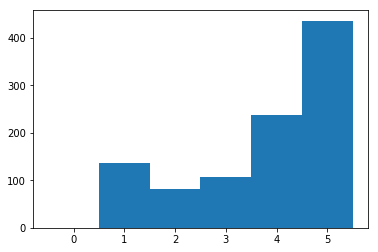

In [11]:
plt.hist(stars[:1000], range=(-0.5, 5.5), bins=6)

Please note that the number of stars ranges from 1 to 5, so it's not possible for a reviewer to give no star. 

Then, we want to split the dataset in two categories that have roughly the same number of examples.

If we were to define as positive the examples with 3 stars or more, the positive category would be much larger than the negative one. 

I prefer to define as positive all reviews with 4 stars or more. Technically, here is how to define the targets:

In [12]:
# first fill an array with zeros, 
# with the same shape as stars
y = np.zeros_like(stars)
# then write 1 if the number of stars is 4 or 5
y[stars>3.5] = 1
print(y, len(y))
print(stars, len(stars))

[1 0 1 ... 0 0 0] 6685900
[5 3 5 ... 1 1 3] 6685900


As usual, we split the dataset into a training and a test sample. At first, we will use 20000 examples for the test sample, and "only" 100,000 examples for the training sample:

In [13]:
n_test = 20000
n_train = 100000
x_test = x[:n_test]
y_test = y[:n_test]
x_train = x[n_test:n_train+n_test]
y_train = y[n_test:n_train+n_test]

## Sentiment analysis with a simple dense network

Our first deep neural network will contain: 

* an embedding layer 
  * cf. [word embedding and simple sentiment analysis](https://thedatafrog.com/word-embedding-sentiment-analysis) for more information about embedding
* a dense layer, responsible for interpreting the results of the embedding
  * cf. [handwritten digit recognition with scikit-learn](https://thedatafrog.com/handwritten-digit-recognition-scikit-learn/) for a beginner introduction to dense neural networks
* a final sigmoid neuron that will output the probability for the review to be positive 
  * cf. [the 1-neuron network: logistic regression](https://thedatafrog.com/logistic-regression/) for a detailed discussion of the final sigmoid neuron.

We start by creating an empty model:

In [14]:
model = keras.Sequential()

The first layer will be the embedding layer. Its role is to convert each integer representing a word into a vector in N-dimensional space. In this space, words with similar meaning will be grouped together.

Following the [keras documentation](https://keras.io/layers/embeddings/), we indicate the number of possible words, the dimension of the embedding space, and the maximum size of the text. 

We start with a 2-dimensional embedding space, as we had done in [word embedding and simple sentiment analysis](https://thedatafrog.com/word-embedding-sentiment-analysis). That's a very low number of dimensions. In fact, typically, embedding is done in 10-100 dimensions. 

But as usual, it's good to start small. We will try and increase the number of dimensions of the embedding space later to see if it improves performance.

In [15]:
review_length = len(x_train[0])
model.add(keras.layers.Embedding(len(vocab.words), 2, 
                                 input_length=review_length))

The output of the embedding is multidimensional. Indeed, we start with a 1D array with 250 words. Since embedding gives us a two-dimensional vector for each word, the embedding layer spits out an array of shape (250, 2). This 2D array cannot be used directly as input to a dense layer, so we need to flatten it into a 1D array with 500 slots. This is done by the Flatten layer: 

In [16]:
model.add(keras.layers.Flatten())

Then, we add dropout regularization. In a nutshell, the dropout regularization layer drops, on a random basis, a fraction of its input values. This forces the network to learn different paths to solve the problem, and helps reduce [overfitting](https://thedatafrog.com/overfitting-illustrated/). If you want to know a bit more about dropout regularization, [check this out](https://thedatafrog.com/deep-learning-keras/#Dropout-layers). 

Here we decide to drop 40% of the values from the Flatten layer:

In [17]:
model.add(keras.layers.Dropout(rate=0.4))

After that, we can add a dense layer, which will analyze the results of the embedding. Again, we start small, with only 5 neurons. We will see later if performance can be improved by increasing the number of neurons.

In [18]:
model.add(keras.layers.Dense(5))

And finally, we end with a dense layer consisting of a single neuron with a [sigmoid activation function](https://thedatafrog.com/logistic-regression/). Therefore, this neuron will produce a value between 0 and 1, which is the estimated probability for the example review to be positive. 

In [19]:
model.add(keras.layers.Dense(1, activation='sigmoid'))

We can now compile and print the full model: 

In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 2)            40004     
_________________________________________________________________
flatten_1 (Flatten)          (None, 500)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2505      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 42,515
Trainable params: 42,515
Non-trainable params: 0
_________________________________________________________________


We fit the model on the training dataset:

In [21]:
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=1000,
                    validation_data=(x_test, y_test),
                    verbose=1)

Train on 100000 samples, validate on 20000 samples
Epoch 1/10
100000/100000 [==============================] - 8s 79us/step - loss: 0.6192 - acc: 0.6719 - val_loss: 0.5592 - val_acc: 0.7271
Epoch 2/10
100000/100000 [==============================] - 7s 67us/step - loss: 0.4592 - acc: 0.7890 - val_loss: 0.3570 - val_acc: 0.8552
Epoch 3/10
100000/100000 [==============================] - 7s 67us/step - loss: 0.3297 - acc: 0.8627 - val_loss: 0.2888 - val_acc: 0.8851
Epoch 4/10
100000/100000 [==============================] - 7s 67us/step - loss: 0.2865 - acc: 0.8851 - val_loss: 0.2647 - val_acc: 0.9003
Epoch 5/10
100000/100000 [==============================] - 7s 67us/step - loss: 0.2662 - acc: 0.8928 - val_loss: 0.2549 - val_acc: 0.9004
Epoch 6/10
100000/100000 [==============================] - 7s 73us/step - loss: 0.2557 - acc: 0.8976 - val_loss: 0.2500 - val_acc: 0.9020
Epoch 7/10
100000/100000 [==============================] - 8s 80us/step - loss: 0.2464 - acc: 0.9026 - val_loss: 0

We see that we end up with a validation accuracy of about 90%. To have a look at the performance in more details, we will use the following function: 

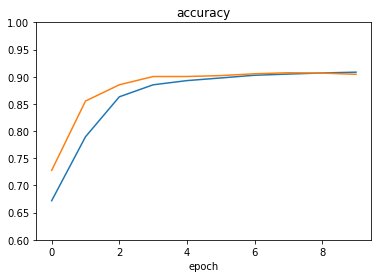

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
def plot_accuracy(history, miny=None):
    '''Plot the training and validation accuracy'''
    acc = history.history['acc']
    test_acc = history.history['val_acc']
    epochs = range(len(acc))
    plt.plot(epochs, acc)
    plt.plot(epochs, test_acc)
    if miny:
        plt.ylim(miny, 1.0)
    plt.title('accuracy') 
    plt.xlabel('epoch')
    plt.figure()
    
plot_accuracy(history, miny=0.6)

The training accuracy plateaus at 90%, so training further will not help much. 

What we see here is that this network underfits the data, meaning that architecture is not complex enough to fit the data. By making it more complex, the training and testing accuracies can certainly be improved. A visual illustration of underfitting is shown [here](https://thedatafrog.com/overfitting-illustrated/#So-why-do-we-need-complex-networks-then?).

## Dense network: increasing complexity

After some tuning, I converged to the following architecture. The structure of the network is complex, so I use the full dataset to avoid overfitting. 

You can now execute the cell below and go grab a coffee.

In [26]:
n_test = 20000
x_test = x[:n_test]
y_test = y[:n_test]
x_train = x[n_test:]
y_train = y[n_test:]

model = keras.Sequential()
model.add(keras.layers.Embedding(len(vocab.words), 128, 
                                 input_length=review_length))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.4))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train,
                    y_train,
                    epochs=3,
                    batch_size=1000,
                    validation_data=(x_test, y_test),
                    verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 128)          2560256   
_________________________________________________________________
flatten_3 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               3200100   
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total para

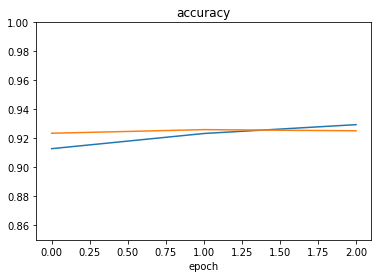

<Figure size 432x288 with 0 Axes>

In [27]:
plot_accuracy(history,miny=0.85)

That's an improvement over the previous attempt, but the training is quite long, and it seems we will not be able to reach 93% classification accuracy on the test sample with this technique. In the next section we try a different strategy. 

## Sentiment analysis with a convolutional network

We introduced convolutional layers when we tuned a [deep convolutional network for image recognition](https://thedatafrog.com/deep-learning-keras/). 

In this tutorial, the convolutional layer consists of a small window called the kernel which scans the image and extracts features at each position. The great advantage of convolutional layers for image recognition is that they can recognize parts of an image wherever these parts are in the image. Also, convolutional layers consider the pixels of the kernel together, which allows them to find local relationships between these pixels. 

In natural language processing, we deal with a sentence, not an image, but we can make the following analogies: 

* image: sentence
* pixel: word
* 2D convolution: 1D convolution

In this section, we will introduce a 1D convolutional layer in our network, with a kernel size of 3. The following sentences illustrate how the convolutional layer will deal with a given review. At each step, the kernel moves by one word, and the words currently scanned by the kernel are indicated in boldface: 

* **this movie is** really not good
* this **movie is really** not good
* this movie **is really not** good
* this movie is **really not good** 

**really not good** carries a lot of information for our sentiment analysis. The convolutional layer will find it whatever its position in the sentence. Also, it will be easy for the network to understand the meaning of **not good**. On the contrary, in our previous attempt, **not** and **good** are not directly considered together. 

Let's try. In the example below, the convolutional layer is set up with: 

* a kernel size of 3,
* 64 filters. This means that 64 features (values) will be extracted from each position of the kernel,
* a ReLU activation, as usual. 


In [28]:
n_test = 20000
n_train = 1000000
x_test = x[:n_test]
y_test = y[:n_test]
x_train = x[n_test:n_test+n_train]
y_train = y[n_test:n_test+n_train]

model = keras.Sequential()

model.add(keras.layers.Embedding(len(vocab.words), 64, input_length=250))
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.4))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train,
                    y_train,
                    epochs=3,
                    batch_size=1000,
                    validation_data=(x_test, y_test),
                    verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 250, 64)           1280128   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 248, 64)           12352     
_________________________________________________________________
flatten_4 (Flatten)          (None, 15872)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15872)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                793650    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 2,086,181
Trainable params: 2,086,181
Non-trainable params: 0
_________________________________________________________________


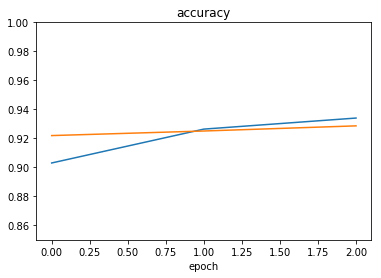

<Figure size 432x288 with 0 Axes>

In [29]:
plot_accuracy(history,miny=0.85)

With the convolutional layer, we get the same performance as with our best try with a simple dense network. However, please note that: 

* there are only 2 million parameters in the network, instead of 10 million
* the convolutional network is less subject to overfitting, and we could restrict the number of training examples to 1 million instead of 6.7 millions, and the training was much faster
* there is room for optimization 


## Stacked convolutional layers 

In this section, we will optimize our convolutional network further by stacking convolutional layers. 

As we have done in [Tuning a deep convolutional network for image recognition](https://thedatafrog.com/deep-learning-keras/), we perform **max pooling** between each convolutional layer, and the layers extract more and more features as we progress in the network. 

To avoid overfitting, we use the whole dataset for training except for 20000 events that are kept for testing. 

In [30]:
n_test = 20000
x_test = x[:n_test]
y_test = y[:n_test]
x_train = x[n_test:]
y_train = y[n_test:]

model = keras.Sequential()

model.add(keras.layers.Embedding(len(vocab.words), 64, input_length=250))

model.add(keras.layers.Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.5))

model.add(keras.layers.Dense(100, activation='relu'))

model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train,
                    y_train,
                    epochs=4,
                    batch_size=1000,
                    validation_data=(x_test, y_test),
                    verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 250, 64)           1280128   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 250, 16)           3088      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 125, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 125, 32)           1568      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 62, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 62, 64)            6208      
_________________________________________________________________
flatten_5 (Flatten)          (None, 3968)              0         
__________

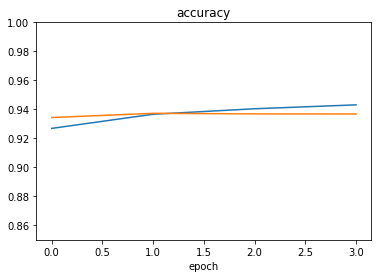

<Figure size 432x288 with 0 Axes>

In [31]:
plot_accuracy(history,miny=0.85)

Nice! 93.7% accuracy, and only a tiny bit of overfitting. There is probably some room for optimization, so please let us know in the comments if you manage to do better with convolutional layers.

## Investigating the misclassified reviews

It's always interesting to look at misclassified examples to get a hint of what's going on and maybe get ideas for further improvements. That's what we're going to do now, with the first 100 examples. 

Here are the predictions and the true labels for these samples: 

In [32]:
x_sample = x_test
y_sample = y_test
preds = model.predict_classes(x_sample)
preds = np.array(preds).flatten()
print('true:')
print(y_sample)
print('predictions:')
print(preds)

true:
[1 0 1 ... 0 1 1]
predictions:
[1 1 1 ... 0 1 1]


Now, we select the misclassified examples, together with the true label and the prediction for these examples:

In [33]:
idx = preds!=y_sample
miscl = x_sample[idx]
miscl_pred = preds[idx]
miscl_true = y_sample[idx]

And we print the first five: 

In [34]:
for pred, true, rev in zip(miscl_pred[:5], miscl_true, miscl[:5]):
    rev = rev[rev!=0] # remove padding
    print(pred, true)
    print(' '.join(vocab.decode(rev)))
    print('\n')

1 0
on wet snowy sunday afternoon made trek out famous fairmount bagels since st. close decided pick up some from there as well compare each other as well as bagels all name research people ! fairmount vs. st. bagels from both locations were fresh from oven still warm when they were handed us ca n't say preferred one over other eventually bagels from both locations were mixed up could n't pick out which ones came from where they were also both great with cream cheese & smoked salmon montreal vs. ny : both respectable their own way ny counterparts & thicker can taken more seriously as meal montreal bagels thinner with more crust crumb ratio best eaten as snack love snacks overall enjoy all bagels refuse play this silly game favorites


1 0
went this little cozy restaurant with wife quiet intimate romantic resto with attentive owner unpretentious capable staff had crab croquettes caesar salad had salmon ( delicious ! crispy on outside perfectly flaky on inside ) desserts : tiramisu wife 

It's not too easy to understand the reviews with all the missing words, especially the stop words like "the", "I", "a", etc. Still, let's try. 

* 1st review: it seems that this person is comparing two bagel shops. She seems to like both and to refuse to compare them. Still, his rating is negative... 
* 2nd review: the text is clearly super positive but the rating is negative... 
* 3rd review: this person clearly states that this is not a review, and that she wants to ask a question about opening hours...
* 4th review: this is a mixed review. I understand that the food is very good but that the restaurant is too expensive and that there were a few issues. The person still recommends to try it once. 
* 5th review: again a mixed review. 

So it appears we're not doing so bad: among the 5 misclassified reviews, three are weird. The last two ones correspond to borderline cases. 

We can build a pandas dataframe to look at the first 5 misclassified reviews. I know that these misclassified reviews are among the first 100 examples, so I will restrict the dataframe to this range:

In [35]:
import pandas as pd
# take the first 4 columns of the first 100 examples. 
# give meaningful names to these columns
df = pd.DataFrame(data=data[:100,:4], columns=['stars','useful','funny','cool'])
# add a column to mark misclassified reviews: 
df['misc'] = idx[:100]
# print the misclassified lines: 
df[df['misc']==True]

,stars,useful,funny,cool,misc
1,3,5,2,3,True
7,3,0,0,0,True
33,3,0,0,0,True
35,4,1,0,1,True
36,4,0,0,0,True
43,4,2,0,0,True


We don't learn much, only that these reviews are indeed borderline: they have 3 or 4 stars, and we set the boundary between our negative and positive categories between 3 and 4 stars.

We're done. Now let's [go back and wrap up!](https://thedatafrog.com/sentiment-analysis-convolutional-network#wrapup) 